No. of clusters: 5
Do you want to enter initial centroids? YES/NOno
Enter number of iterations: 80
0.33129989764585466
0.7807592150124836


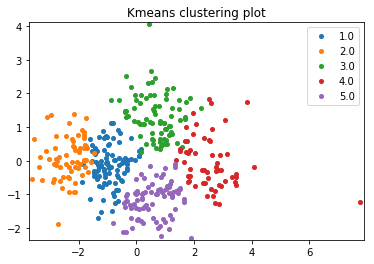

In [48]:
import numpy as np
import sys
from scipy.spatial import distance
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True) #prevent numpy exponential 

def read_data(file):
    gene_data = open(file)
    gene_seq = gene_data.readlines()
    all_genes_list = []
    for line in gene_seq:
        gene = line.strip().split("\t")
        all_genes_list.append(gene)
    return np.asarray(all_genes_list, dtype = float)
        

def kmeans(centroids, total_iterations,iteration_num, data,cluster_id_res):
    if(iteration_num <= total_iterations) :
        bins_centroids = []
        for i in range(0,centroids.shape[0]):
            bins_centroids.append([])
        for row in range(0,data.shape[0]):
            dist_min = sys.maxsize
            c_ind = -1
            for c in range(0,centroids.shape[0]):
                d = distance.euclidean(data[row], centroids[c])
                if (d<=dist_min) :
                    dist_min = d
                    c_ind = c
            bins_centroids[c_ind].append(data[row])
            cluster_id_res[row] = c_ind+1
        centroids = new_centroids(bins_centroids, data)
        return kmeans(centroids,total_iterations,iteration_num+1, data, cluster_id_res)
    else:
        return cluster_id_res

def new_centroids(centroids_list, data):
    c = np.zeros([len(centroids_list), data.shape[1]])
    for i in range(0,len(centroids_list)):
        cluster = np.asarray(centroids_list[i])
        c[i] = cluster.mean(axis = 0)
    return c

def compute_similarity_terms(gene_data, cluster_ids):
    m11 = 0
    m01 = 0
    m10 = 0
    m00 = 0
    for g1 in range(0,gene_data.shape[0]):
        g1_ground_truth = gene_data[g1][1]
        g1_cluster_id = cluster_ids[g1]
        for g2 in range(0, gene_data.shape[0]):
            g2_ground_truth = gene_data[g2][1]
            g2_cluster_id = cluster_ids[g2]
            if(g1_ground_truth == g2_ground_truth and g1_cluster_id == g2_cluster_id):
                m11 += 1
            elif(g1_ground_truth == g2_ground_truth and g1_cluster_id != g2_cluster_id):
                m10 += 1
            elif(g1_ground_truth != g2_ground_truth and g1_cluster_id == g2_cluster_id):
                m01 += 1
            elif(g1_ground_truth != g2_ground_truth and g1_cluster_id != g2_cluster_id):
                m00 += 1
    return m11, m01, m10, m00

def plot_PCA(gene_features,cluster_ids):
    pca = PCA(n_components = 2)
    data_reduced = pca.fit_transform(gene_features)

    # Appending disease column to dimensionally reduced data
    cluster_ids = cluster_ids.reshape(gene_features.shape[0],1)
    newData = np.hstack((data_reduced,cluster_ids))

    #Plotting the 2D data
    newDf = pd.DataFrame(data = newData)
    groups = newDf.groupby(newDf.columns[newData.shape[1]-1])

    fig, ax = plt.subplots()
    plt.title('Kmeans clustering plot')
    ax.margins(0.01)
    for name, group in groups:
        ax.plot(group[0], group[1], marker='o', linestyle='', ms=4, label=name)
    ax.legend(numpoints=1, loc='best')

    plt.show()

#KMeans Clustering algorithm
gene_data = read_data("cho.txt")
cluster_count = int(input('No. of clusters: '))
centroid_selection = input('Do you want to enter initial centroids? YES/NO')
initial_centroid_indices = []
if centroid_selection.lower() == 'yes':
    c_string = input('Enter centroids as comma seperated values: ')
    initial_centroid_indices = list(map(int,c_string.split(',')))
else:
    initial_centroid_indices = np.random.choice(len(gene_data),cluster_count,replace = False)
iterations_count = int(input('Enter number of iterations: '))
gene_features = gene_data[:,2:]
centroid_values = []
for i in range(cluster_count):
    centroid_values.append(gene_features[initial_centroid_indices[i]-1])
cluster_ids = np.zeros(gene_data.shape[0])

cluster_ids = kmeans(np.asarray(centroid_values), iterations_count,1,gene_features,cluster_ids)

m11, m01, m10, m00 = compute_similarity_terms(gene_data, cluster_ids)
jacard_coef = float(m11)/float(m11+m10+m01)
print(jacard_coef)

rand_index = float(m11+m00)/float(m11+m10+m01+m00)
print(rand_index)

#Plot PCA for gene_features data set
plot_PCA(gene_features,cluster_ids)
